In [1]:
import os
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
import re
import matplotlib.pyplot as plt
import numpy as np
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

In [2]:
import impedance
print(impedance.__file__)

/Users/sushankmishra/Library/Python/3.9/lib/python/site-packages/impedance/__init__.py


## Base Indicators

In [2]:
base_path = '/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge'

# List all files matching stddischarge format
files = [f for f in os.listdir(base_path) if re.match(r'0_\d+_1_stddischarge\.csv', f)]

# Sort files numerically by cycle number
files.sort(key=lambda x: int(x.split('_')[1]))


## Capacity at different Cycles

In [3]:
results = []
for file in files:
    # Extract cycle number from filename
    cycle = int(file.split('_')[1])
    
    # Load CSV file
    df = pd.read_csv(os.path.join(base_path, file), header=None, names=['Time', 'Voltage', 'Current'],delimiter='\t')
    # Convert strings to float (in case CSVs contain text or malformed entries)
    df = df.apply(pd.to_numeric, errors='coerce')

    # Drop any rows with NaNs (caused by bad formatting)
    df = df.dropna()
    # Ensure time is sorted (just in case)
    df = df.sort_values(by='Time')

    # Integrate current over time to get capacity in Ah
    # Current is assumed to be negative during discharge
    time = df['Time'].values  # in seconds
    current = df['Current'].values  # in A

    # Compute charge in As (Amp-seconds), then convert to Ah
    capacity_As = np.trapz(-current, time)  # negative current during discharge
    capacity_Ah = capacity_As / 3600

    results.append((cycle, capacity_Ah))

## SoH at different Cycles

In [4]:
results_df = pd.DataFrame(results, columns=['Cycle', 'Discharge_Capacity_Ah'])

# Compute SoH (as capacity relative to cycle 0)
initial_capacity = results_df.iloc[0]['Discharge_Capacity_Ah']
results_df['SoH'] = results_df['Discharge_Capacity_Ah'] / initial_capacity

# Display the result
# results_df.head()
for i, row in results_df.iterrows():
    print(f"Cycle {int(row['Cycle']):>3}: Capacity = {-1*row['Discharge_Capacity_Ah']:.4f} Ah, SoH = {row['SoH']:.2%}")
import pandas as pd

# Assuming results_df is your DataFrame
# Save the DataFrame to a CSV file
results_df.to_csv('results.csv', index=False)

# Add a title to the file (CSV files don't natively support titles, so you can prepend it manually)
with open('results.csv', 'r') as file:
    data = file.readlines()

# Prepend the title to the file
title = "SoH Values at Different Cycles for LiPo-1 \n"
data.insert(0, title)

# Write the updated content back to the file
with open('results.csv', 'w') as file:
    file.writelines(data)

Cycle   0: Capacity = 3.6645 Ah, SoH = 100.00%
Cycle  45: Capacity = 3.5569 Ah, SoH = 97.06%
Cycle  90: Capacity = 3.4088 Ah, SoH = 93.02%
Cycle 116: Capacity = 3.3411 Ah, SoH = 91.17%
Cycle 135: Capacity = 3.2716 Ah, SoH = 89.28%
Cycle 180: Capacity = 2.9352 Ah, SoH = 80.10%
Cycle 204: Capacity = 2.8412 Ah, SoH = 77.53%


In [6]:
# !pip install impedance

# Define the modified circuit string
# circuit = 'R0-p(R1-CPE1)-p(R2-W1,CPE2)'
# circuit = 'R0-p(R1-W1,CPE1)'
circuit = 'R1-p(CPE2,R2-Wo3)-W1'

initial_guess = [
    0.1,      # R1
    1e-5,     # CPE2_T
    0.9,      # CPE2_P
    200,      # R2
    1.0,      # Wd3_R
    1e-5,     # Wd3_T    # W1_R
    1e-5      # W1_T
]


# Initial guess for parameters: [R0, R1, CPE1_T, CPE1_P, R2, CPE2_T, CPE2_P, W1_R, W1_T]
# initial_guess = [0.1, 50, 1e-5, 0.9, 200, 1e-5, 0.9, 1]
# initial_guess = [0.1, 200, 1, 1e-5, 0.9]

# Create the circuit model
circuit_model = CustomCircuit(initial_guess=initial_guess, circuit=circuit)
# circuit_model.fit(f_x, Z)

# Plot the fitted circuit model
# fig, ax = plt.subplots(figsize=(6, 6))
# plot_nyquist(Z, ax=ax)
# plot_nyquist(circuit_model.predict(f_x), ax=ax, fmt='-')
# ax.legend(['Experimental', 'Fitted'])
# plt.grid(True)
# plt.title("Fitted Nyquist Plot of EIS Data", fontsize=16)
# plt.xlabel("Z' (Real Part) [Ohm]", fontsize=10)
# plt.ylabel("-Z' (Imaginary Part) [Ohm]", fontsize=10)
# plt.show()

In [ ]:
# Initialize an empty DataFrame to store results
results_data = []
# results_df.set_index('Cycle', inplace=True)

# Base path for EIS data
base_path = '/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge'

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through all EIS folders (EIS_0, EIS_10, ...)
files = [f for f in os.listdir(base_path) if re.match(r'EIS+_\d', f)]
files.sort(key=lambda x: int(x.split('_')[1]))

for folder in files:
    folder_path = os.path.join(base_path, folder)
    if folder.startswith('EIS_') and os.path.isdir(folder_path):
        cycle_num = int(folder.split('_')[1])  # e.g., EIS_45 → 45
        eis_file = os.path.join(folder_path, '1_EIS.csv')  # SoC index 5

        if os.path.exists(eis_file):
            # Load EIS spectrum
            # print(f"Processing {eis_file} for Cycle {cycle_num}")
            df = pd.read_csv(eis_file, header=None, names=['Freq', 'Re', 'Im'], delimiter='\t')
            freq = df['Freq'].values
            Z_re = df['Re'].values
            Z_im = df['Im'].values

            # Fit the circuit model
            Z = Z_re + 1j * Z_im
            circuit_model.fit(freq, Z)

            # Get fitted parameters
            fitted_parameters = circuit_model.parameters_

            # Extract parameter names
            nested_param_names = circuit_model.get_param_names()
            param_names = [item for sublist in nested_param_names for item in (sublist if isinstance(sublist, list) else [sublist])]

            # Create a dictionary to store the row data
            row_data = {
                'SoC': 90,  # Assuming SoC is 90% for all files
                'Cycle': cycle_num,
                'SoH': results_df.loc[cycle_num, 'SoH'] if cycle_num in results_df.index else None
                # Alternatively, for rounding use:
                # 'SoH': round(results_df.loc[cycle_num, 'SoH'], 2) if cycle_num in results_df.index else None
            }
            
            # Add circuit parameters to the row data
            for name, value in zip(param_names, fitted_parameters):
                row_data[name] = value

            # Append the row data to the results list
            results_data.append(row_data)

            # Plot using impedance-style: negative imaginary axis
            label = f"Cycle {cycle_num} - SoH {row_data['SoH']:.0%}" if row_data['SoH'] is not None else f"Cycle {cycle_num}"
            row_data['SoH'] = f"{row_data['SoH']:.0%}"  # Set SoC to 90% for all entries
            ax.plot(Z_re, -Z_im, label=label, linestyle='-', linewidth=2.5, marker='o')

# Customize the plot
ax.set_xlabel('Re(Z) [Ω]', fontsize=26, fontweight='bold')
ax.set_ylabel('-Im(Z) [Ω]', fontsize=26, fontweight='bold')
ax.set_title('EIS Spectra at SoC 90% with different SoH', fontsize=26, pad=20)
ax.tick_params(axis='both', which='major', labelsize=24)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
ax.legend(fontsize=18)
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
plt.tight_layout()
plt.show()

# Convert results data to a DataFrame
results_new = pd.DataFrame(results_data)

# Save the results DataFrame to an Excel file
output_file = 'LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/EIS_Fitting_Results.csv'

# Check if the file already exists
if not os.path.exists(output_file):
    # If the file doesn't exist, write the DataFrame with the header
    results_new.to_csv(output_file, index=False)
else:
    # If the file exists, append the data without writing the header
    results_new.to_csv(output_file, mode='a', index=False, header=False)

## Main Algo

In [ ]:
results_data = []

# File paths
soc = 10
filelist_path = f"/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/soc_val/EISFiles_SoC{soc}.csv"
base_eis_path = "/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/EIS_{x}/{y}_EIS.csv"

# Read the filelist.txt to get x and y values
filelist_df = pd.read_csv(filelist_path, header=None, names=['x', 'y'], delimiter='\t', index_col=False)
print(filelist_df)
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through each row in the filelist
for _, row in filelist_df.iterrows():
    x = row['x']
    y = row['y']

    # Construct the EIS file path
    eis_file = base_eis_path.format(x=x, y=y)

    if os.path.exists(eis_file):
        df = pd.read_csv(eis_file, header=None, names=['Freq', 'Re', 'Im'], delimiter='\t')
        freq = df['Freq'].values
        Z_re = df['Re'].values
        Z_im = df['Im'].values

        # Fit the circuit model
        Z = Z_re + 1j * Z_im
        circuit_model.fit(freq, Z)

        # Get fitted parameters
        fitted_parameters = circuit_model.parameters_

        # Extract parameter names
        nested_param_names = circuit_model.get_param_names()
        param_names = [item for sublist in nested_param_names for item in (sublist if isinstance(sublist, list) else [sublist])]
        cycle_num = int(x)  # Assuming x corresponds to the cycle number
        soh = results_df.loc[cycle_num, 'SoH'] if cycle_num in results_df.index else None
        # Create a dictionary to store the row data
        row_data = {
            'SoC': soc,  # Assuming SoC is 90% for all files
            'Cycle': cycle_num,
            'SoH': soh
            # 'SoH': round(results_df.loc[cycle_num, 'SoH'], 2) if cycle_num in results_df.index else None
        }
        
        # Add circuit parameters to the row data
        for name, value in zip(param_names, fitted_parameters):
            row_data[name] = value

        # Append the row data to the results list
        results_data.append(row_data)

        # Plot using impedance-style: negative imaginary axis
        label = f"Cycle {cycle_num} - SoH {row_data['SoH']:.0%}" if row_data['SoH'] is not None else f"Cycle {cycle_num}"
        row_data['SoH'] = f"{row_data['SoH']:.0%}"  # Set SoC to 90% for all entries
        ax.plot(Z_re, -Z_im, label=label, linestyle='-', linewidth=2.5, marker='o')

# Customize the plot
ax.set_xlabel('Re(Z) [Ω]', fontsize=26, fontweight='bold')
ax.set_ylabel('-Im(Z) [Ω]', fontsize=26, fontweight='bold')
ax.set_title(f'EIS Spectra at SoC {soc}% with different SoH', fontsize=26, pad=20)
ax.tick_params(axis='both', which='major', labelsize=24)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
ax.legend(fontsize=18)
for spine in ax.spines.values():
    spine.set_linewidth(2.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
# Convert results data to a DataFrame
results_new = pd.DataFrame(results_data)

# Save the results DataFrame to an Excel file
output_file = 'LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/EIS_Fitting_Results.csv'

# Check if the file already exists
if not os.path.exists(output_file):
    # If the file doesn't exist, write the DataFrame with the header
    results_new.to_csv(output_file, index=False)
else:
    # If the file exists, append the data without writing the header
    results_new.to_csv(output_file, mode='a', index=False, header=False)

## Checking post neglect of less than 0 values of -Z_im

Processing SoC: 10%
     x   y
0    0  10
1   45   9
2   90   9
3  116   9
4  135   9
5  180   9
6  204   9
Processing SoC: 20%
     x  y
0    0  9
1   45  8
2   90  8
3  116  8
4  135  8
5  180  8
6  204  8
Processing SoC: 30%
     x  y
0    0  8
1   45  7
2   90  7
3  116  7
4  135  7
5  180  7
6  204  7
Processing SoC: 40%
     x  y
0    0  7
1   45  6
2   90  6
3  116  6
4  135  6
5  180  6
6  204  6
Processing SoC: 50%
     x  y
0    0  6
1   45  5
2   90  5
3  116  5
4  135  5
5  180  5
6  204  5
Processing SoC: 60%
     x  y
0    0  5
1   45  4
2   90  4
3  116  4
4  135  4
5  180  4
6  204  4
Processing SoC: 70%
     x  y
0    0  4
1   45  3
2   90  3
3  116  3
4  135  3
5  180  3
6  204  3
Processing SoC: 80%
     x  y
0    0  3
1   45  2
2   90  2
3  116  2
4  135  2
5  180  2
6  204  2
Processing SoC: 90%
     x  y
0    0  2
1   45  1
2   90  1
3  116  1
4  135  1
5  180  1
6  204  1
Processing SoC: 100%
     x  y
0    0  0
1   45  0
2   90  0
3  116  0
4  135  0
5  180  0
6

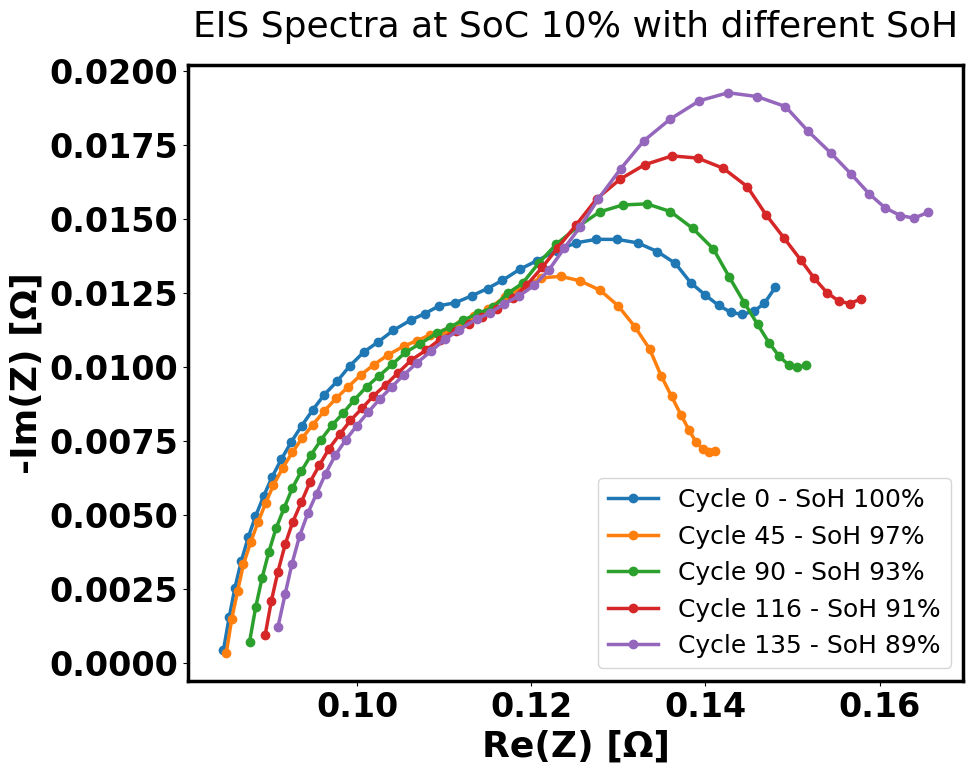

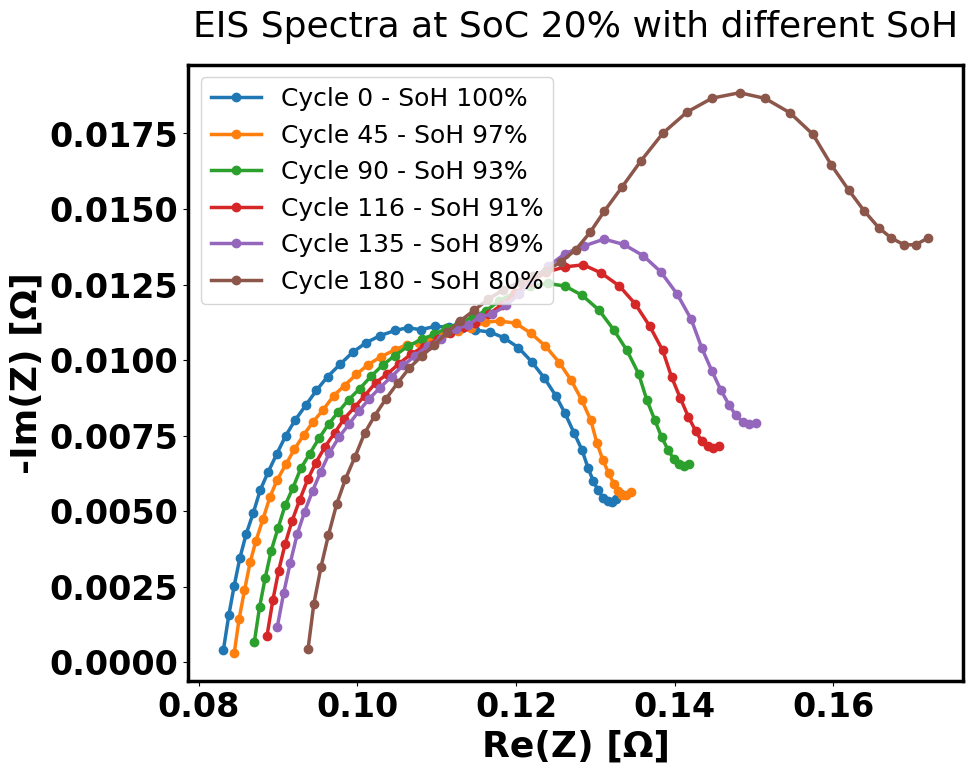

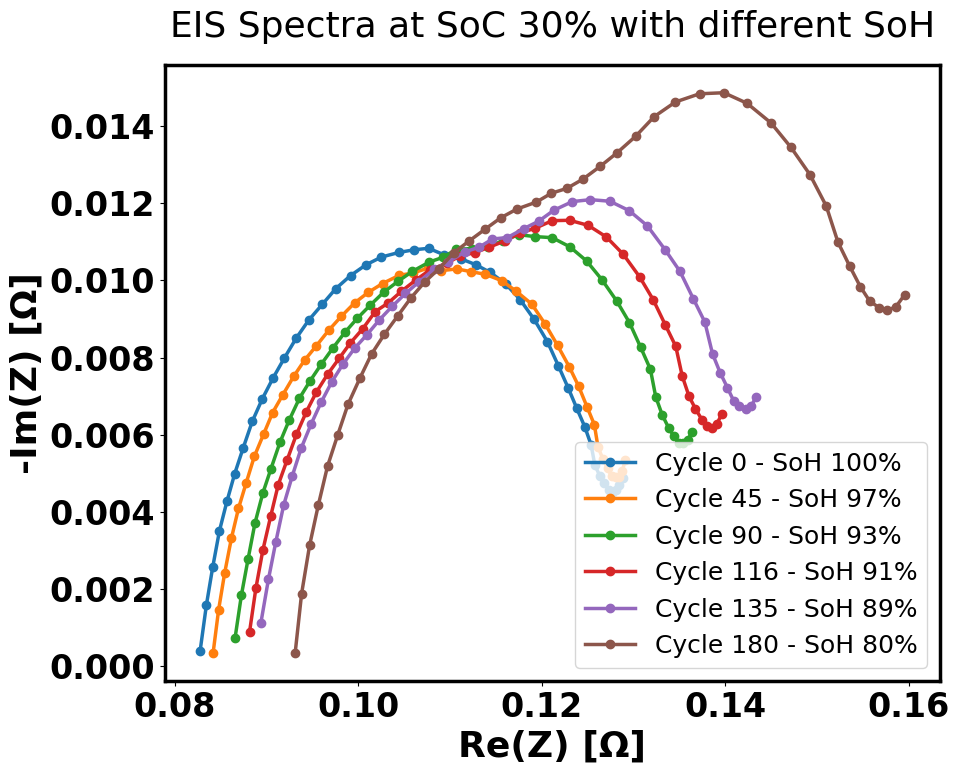

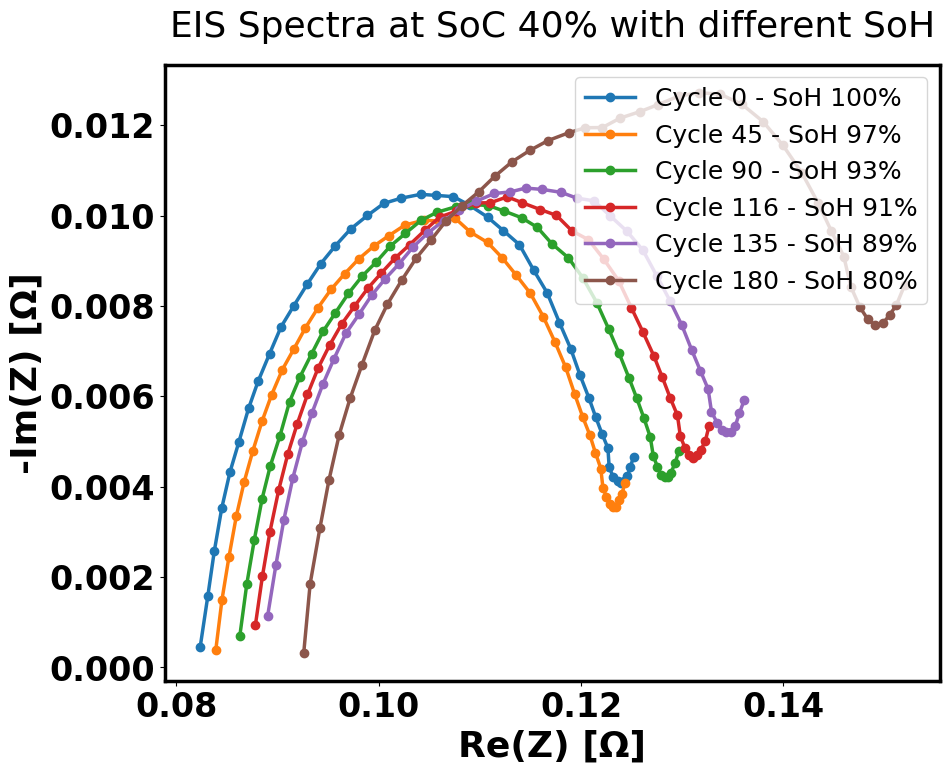

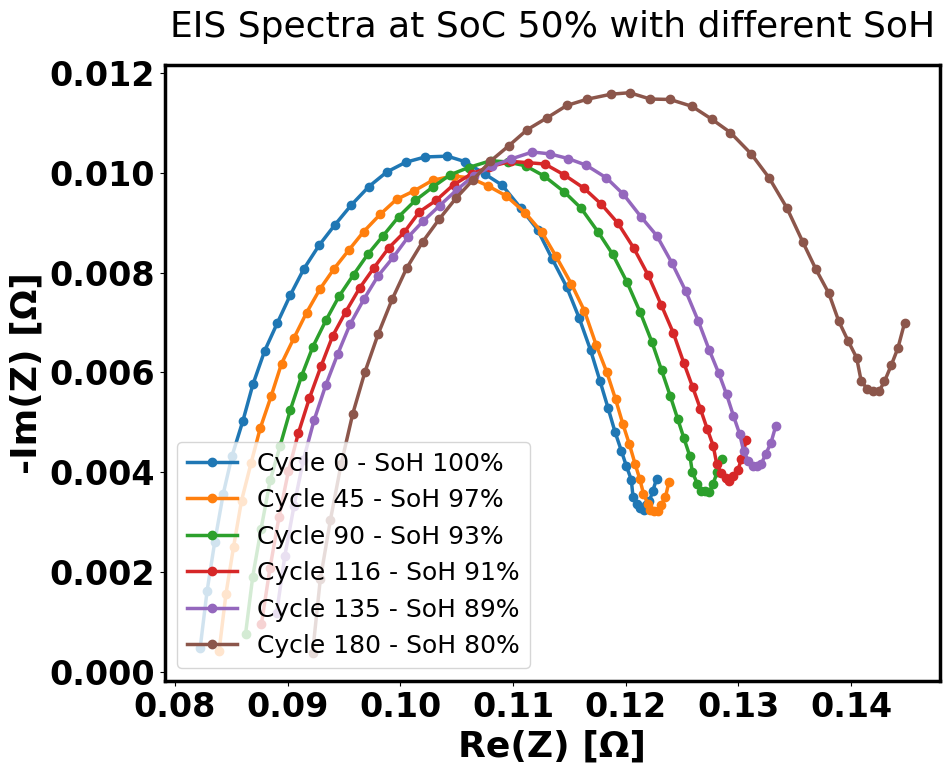

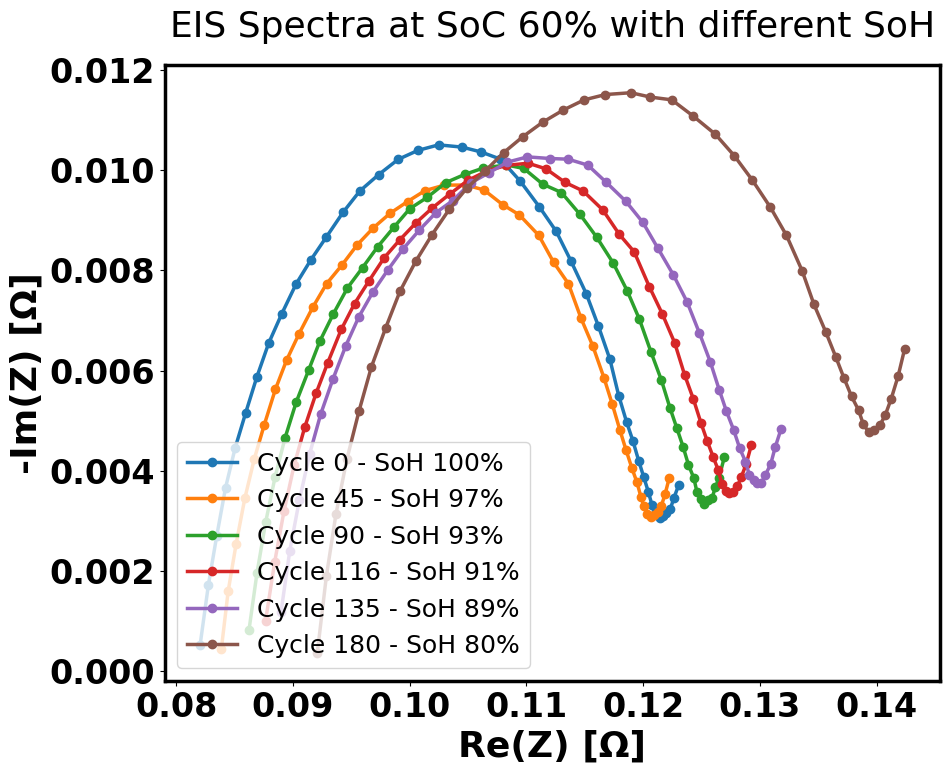

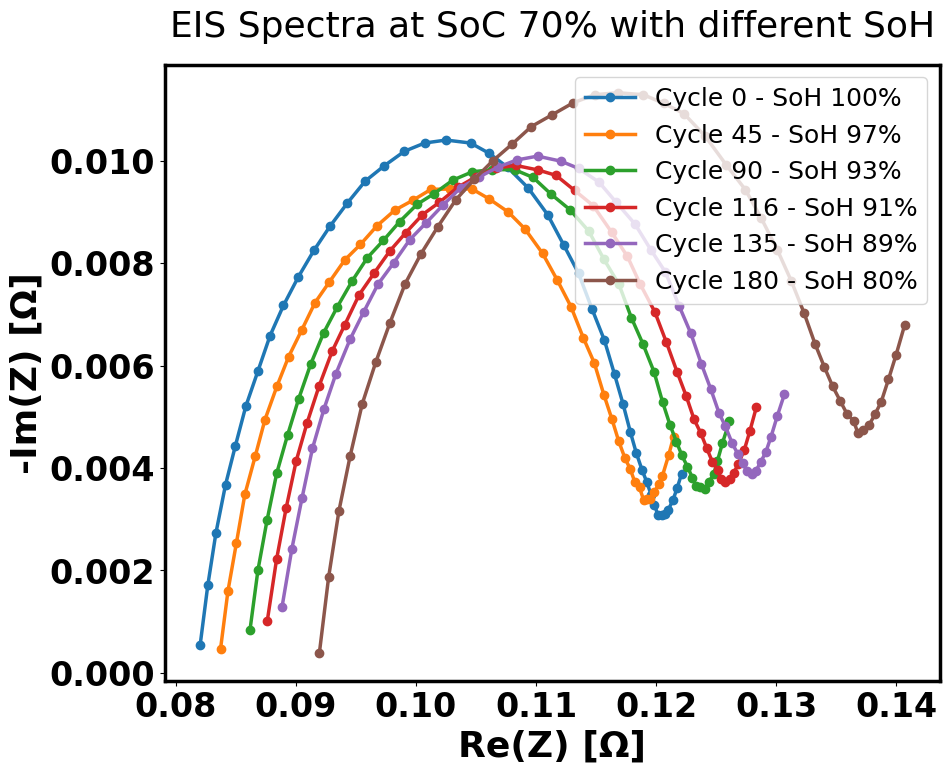

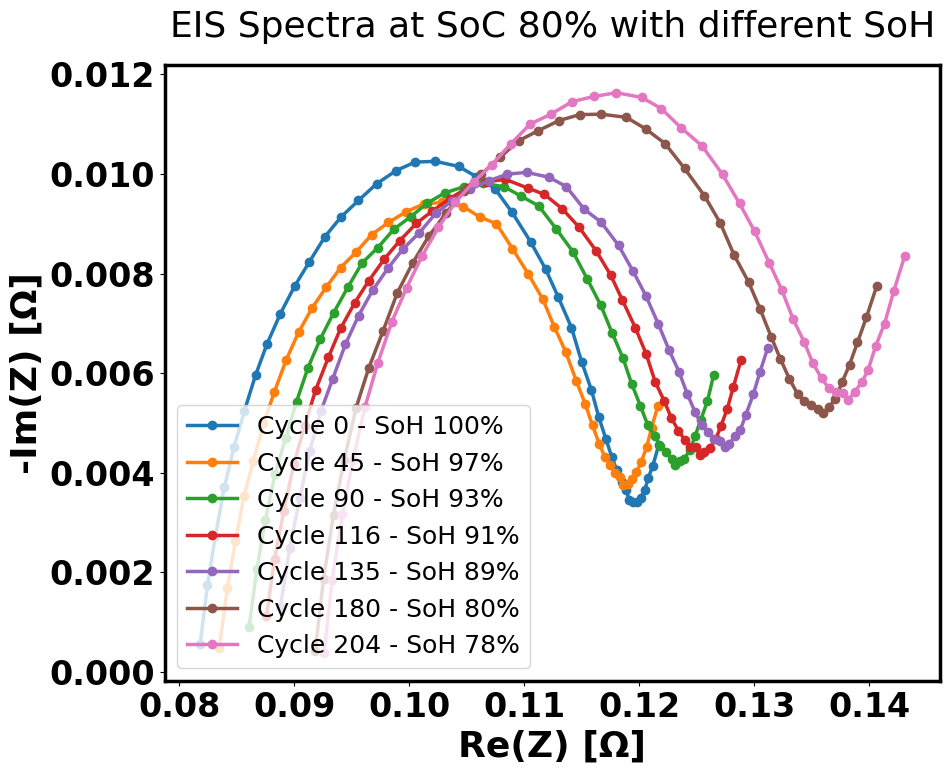

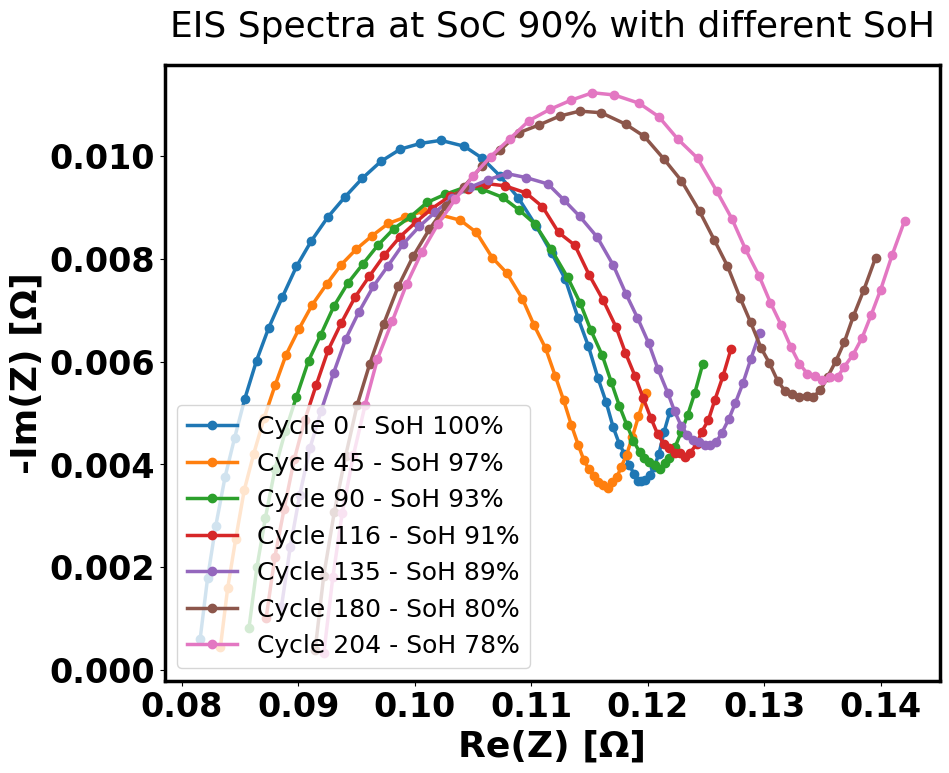

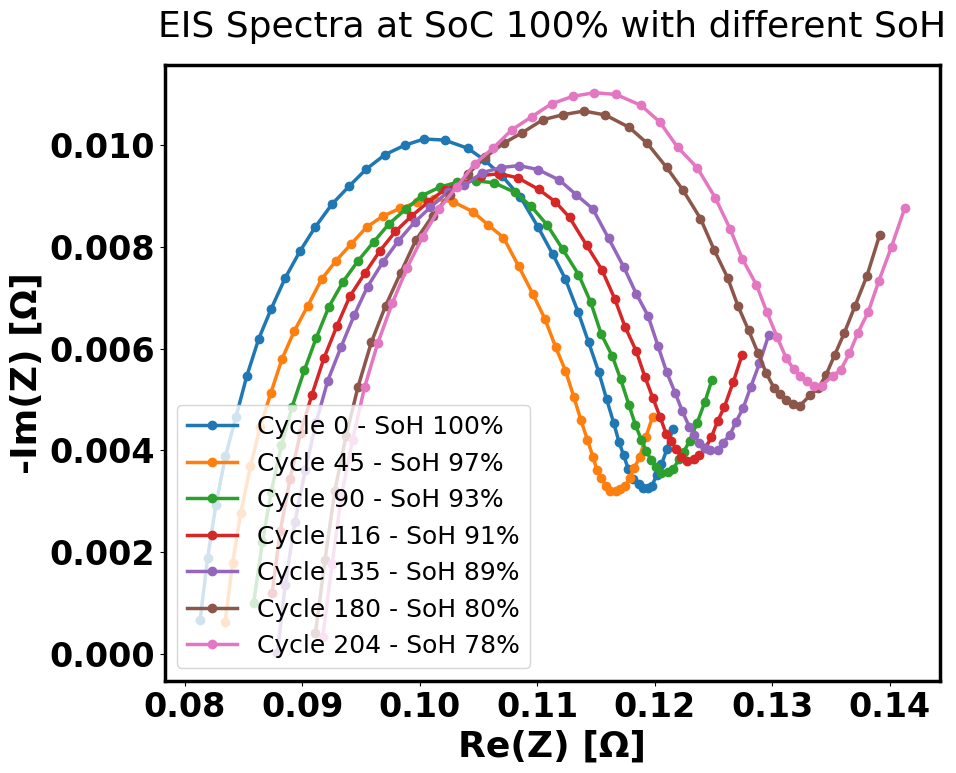

In [ ]:
# results_df.set_index('Cycle', inplace=True)
if results_df.index.name != 'Cycle':
    results_df.set_index('Cycle', inplace=True)
soc = list(range(10, 101, 10))
for soc in soc:
    results_data = []
    print(f"Processing SoC: {soc}%")
    filelist_path = f"/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/soc_val/EISFiles_SoC{soc}.csv"
    base_eis_path = "/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/EIS_{x}/{y}_EIS.csv"

    # Read the filelist.txt to get x and y values
    filelist_df = pd.read_csv(filelist_path, header=None, names=['x', 'y'], delimiter='\t', index_col=False)
    # print(filelist_df)
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Loop through each row in the filelist
    for _, row in filelist_df.iterrows():
        x = row['x']
        y = row['y']

        # Construct the EIS file path
        eis_file = base_eis_path.format(x=x, y=y)

        if os.path.exists(eis_file):
            df = pd.read_csv(eis_file, header=None, names=['Freq', 'Re', 'Im'], delimiter='\t')
            # freq = df['Freq'].values
            # Z_re = df['Re'].values
            # Z_im = df['Im'].values
            
            freq = df['Freq'].values
            Z_re = df['Re'].values
            Z_im = df['Im'].values

            # Filter out values where Z_im < 0
            mask = Z_im >= 0
            freq = freq[~mask]
            Z_re = Z_re[~mask]
            Z_im = Z_im[~mask]

            # Fit the circuit model
            Z = Z_re + 1j * Z_im
            circuit_model.fit(freq, Z)

            # Get fitted parameters
            fitted_parameters = circuit_model.parameters_

            # Extract parameter names
            nested_param_names = circuit_model.get_param_names()
            param_names = [item for sublist in nested_param_names for item in (sublist if isinstance(sublist, list) else [sublist])]
            cycle_num = int(x)  # Assuming x corresponds to the cycle number
            soh = results_df.loc[cycle_num, 'SoH'] if cycle_num in results_df.index else None
            # Create a dictionary to store the row data
            row_data = {
                'SoC': soc,  # Assuming SoC is 90% for all files
                'Cycle': cycle_num,
                'SoH': soh
                # 'SoH': round(results_df.loc[cycle_num, 'SoH'], 2) if cycle_num in results_df.index else None
            }
            
            # Add circuit parameters to the row data
            for name, value in zip(param_names, fitted_parameters):
                row_data[name] = value

            # Append the row data to the results list
            results_data.append(row_data)

            # Plot using impedance-style: negative imaginary axis
            label = f"Cycle {cycle_num} - SoH {row_data['SoH']:.0%}" if row_data['SoH'] is not None else f"Cycle {cycle_num}"
            row_data['SoH'] = f"{row_data['SoH']:.0%}"  # Set SoC to 90% for all entries
            ax.plot(Z_re, -Z_im, label=label, linestyle='-', linewidth=2.5, marker='o')

    # Customize the plot
    ax.set_xlabel('Re(Z) [Ω]', fontsize=26, fontweight='bold')
    ax.set_ylabel('-Im(Z) [Ω]', fontsize=26, fontweight='bold')
    ax.set_title(f'EIS Spectra at SoC {soc}% with different SoH', fontsize=26, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=24)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.legend(fontsize=18)
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    # Adjust layout and show the plot
    # plt.tight_layout()
    # plt.show()
    # Convert results data to a DataFrame
    results_new = pd.DataFrame(results_data)

    # Save the results DataFrame to an Excel file
    output_file = './EIS_Fitting_Results_new.csv'

    # Check if the file already exists
    if not os.path.exists(output_file):
        # If the file doesn't exist, write the DataFrame with the header
        results_new.to_csv(output_file, index=False)
    else:
        # If the file exists, append the data without writing the header
        results_new.to_csv(output_file, mode='a', index=False, header=False)

## Check Fitting of ECM on Data

Fitted Parameters: [0.08485513 0.0352868  0.00583231 0.50295305 0.64888349]
Fitting RMSE for cycle 90: 1.4343e-03 Ω


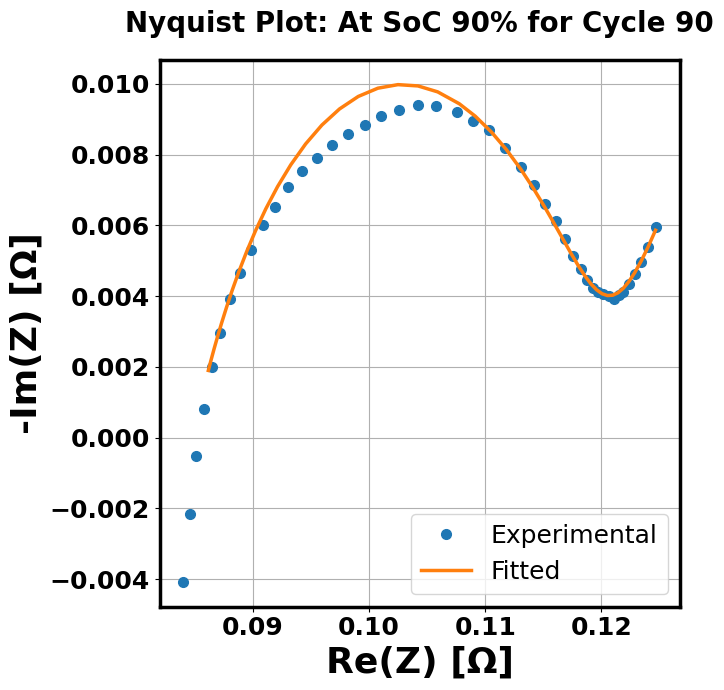

In [4]:
# File paths
soc = 90
cycle = 90  # <-- Set the cycle number you want to plot
filelist_path = f"/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/soc_val/EISFiles_SoC{soc}.csv"
base_eis_path = "/Users/sushankmishra/Desktop/MTP_Materials/EIS Fitting/LiPo Battery LP-503562-IS-3 EIS, Capacity, ECM Data/LiPO_1/EIS_Charge_discharge/EIS_{x}/{y}_EIS.csv"

# Read the filelist to get x and y values
filelist_df = pd.read_csv(filelist_path, header=None, names=['x', 'y'], delimiter='\t', index_col=False)

# Define your circuit and initial guess
circuit = 'R0-p(R1-W1,CPE1)'
initial_guess = [0.1, 200, 1, 1e-5, 0.9]
circuit_model = CustomCircuit(initial_guess=initial_guess, circuit=circuit)
# Filter for the desired cycle
if cycle in filelist_df['x'].values:
    row = filelist_df[filelist_df['x'] == cycle].iloc[0]
    x = row['x']
    y = row['y']
    eis_file = base_eis_path.format(x=x, y=y)

    if os.path.exists(eis_file):
        df = pd.read_csv(eis_file, header=None, names=['Freq', 'Re', 'Im'], delimiter='\t')
        freq = df['Freq'].values
        Z_re = df['Re'].values
        Z_im = df['Im'].values

        # Fit the circuit model
        Z = Z_re + 1j * Z_im
        circuit_model.fit(freq, Z)
        Z_fit = circuit_model.predict(freq)
        print("Fitted Parameters:", circuit_model.parameters_)
        rmse = np.sqrt(np.mean(np.abs(Z - Z_fit) ** 2))
        print(f"Fitting RMSE for cycle {cycle}: {rmse:.4e} Ω")
        # Plot experimental and fitted data
        plt.figure(figsize=(7, 7))
        plt.plot(Z_re, -Z_im, 'o', label='Experimental', markersize=7)
        plt.plot(Z_fit.real, -Z_fit.imag, '-', label='Fitted', linewidth=2.5)
        plt.xlabel("Re(Z) [Ω]", fontsize=26, fontweight='bold')
        plt.ylabel("-Im(Z) [Ω]", fontsize=26, fontweight='bold')
        plt.title(f"Nyquist Plot: At SoC {soc}% for Cycle {x}", fontsize=20, fontweight='bold', pad=20)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.legend(fontsize=18)
        plt.grid(True)
        for spine in plt.gca().spines.values():
            spine.set_linewidth(2.5)
        for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
            label.set_fontweight('bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"EIS file not found for cycle {cycle}")
else:
    print(f"Cycle {cycle} not found in filelist.")

## Tried & tested

In [ ]:
# Read the filelist.txt to get x and y values
filelist_df = pd.read_csv(filelist_path, header=None, names=['x', 'y'], delimiter='\t', index_col=False)
print(filelist_df)
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Loop through each row in the filelist
for _, row in filelist_df.iterrows():
    x = row['x']
    y = row['y']

    # Construct the EIS file path
    eis_file = base_eis_path.format(x=x, y=y)

    if os.path.exists(eis_file):
        # Load the EIS data
        df = pd.read_csv(eis_file, header=None, names=['Freq', 'Re', 'Im'], delimiter='\t', index_col=False)

        # Extract data for plotting
        freq = df['Freq'].values
        Z_re = df['Re'].values
        Z_im = df['Im'].values

        # Get SoH from earlier computed values (assuming results_df and cycle_num are defined)
        cycle_num = int(x)  # Assuming x corresponds to the cycle number
        soh = results_df.loc[cycle_num, 'SoH'] if cycle_num in results_df.index else None

        # Create label for the plot
        label = f"Cycle {cycle_num} - SoH {soh:.0%}" if soh is not None else f"Cycle {cycle_num}"

        # Plot using impedance-style: negative imaginary axis
        ax.plot(Z_re, -Z_im, label=label, linestyle='-', linewidth=2.5, marker='o')

# Customize the plot
ax.set_xlabel('Re(Z) [Ω]', fontsize=26, fontweight='bold')
ax.set_ylabel('-Im(Z) [Ω]', fontsize=26, fontweight='bold')
ax.set_title('EIS Spectra at SoC 90% with different SoH', fontsize=26, pad=20)
ax.tick_params(axis='both', which='major', labelsize=24)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
ax.legend(fontsize=18)
for spine in ax.spines.values():
    spine.set_linewidth(2.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()